<## <small>
Copyright (c) 2017-21 Andrew Glassner

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
</small>



# Deep Learning: A Visual Approach
## by Andrew Glassner, https://glassner.com
### Order: https://nostarch.com/deep-learning-visual-approach
### GitHub: https://github.com/blueberrymusic
------

### What's in this notebook

This notebook is provided as a “behind-the-scenes” look at code used to make some of the figures in this chapter. It is cleaned up a bit from the original code that I hacked together, and is only lightly commented. I wrote the code to be easy to interpret and understand, even for those who are new to Python. I tried never to be clever or even more efficient at the cost of being harder to understand. The code is in Python3, using the versions of libraries as of April 2021. 

This notebook may contain additional code to create models and images not in the book. That material is included here to demonstrate additional techniques.

Note that I've included the output cells in this saved notebook, but Jupyter doesn't save the variables or data that were used to generate them. To recreate any cell's output, evaluate all the cells from the start up to that cell. A convenient way to experiment is to first choose "Restart & Run All" from the Kernel menu, so that everything's been defined and is up to date. Then you can experiment using the variables, data, functions, and other stuff defined in this notebook.

## Chapter 11: Classifers, Notebook 3: Decision Trees

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets.samples_generator import make_moons
from sklearn.tree import DecisionTreeClassifier
import math

import seaborn as sns; sns.set()

/Users/Andrew/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# Make a File_Helper for saving and loading files.

#save_files = True

#import os, sys, inspect
#current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
#sys.path.insert(0, os.path.dirname(current_dir)) # path to parent dir
#from DLBasics_Utilities import File_Helper
#file_helper = File_Helper(save_files)

In [3]:
from matplotlib.colors import LinearSegmentedColormap
dot_clr_0 = np.array((27, 72, 105))/255.
dot_clr_1 = np.array((255, 139, 0))/255.
dot_cmap = LinearSegmentedColormap.from_list('dot_map', [dot_clr_0, dot_clr_1], N=100)
tree_clr_0 = np.array((147, 209, 217))/255. 
tree_clr_1 = np.array((241, 210, 169))/255.
tree_cmap = LinearSegmentedColormap.from_list('tree_map', [tree_clr_0, tree_clr_1], N=100)

In [4]:
def show_Xy(X, y, filename):
    plt.scatter(X[:,0], X[:,1], c=y, s=50, cmap=dot_cmap)
    #file_helper.save_figure(filename)
    plt.show()

In [5]:
def get_plot_vars(X, y):
    xmin = np.min(X[:,0]) - .1
    xmax = np.max(X[:,0]) + .1
    ymin = np.min(X[:,1]) - .1
    ymax = np.max(X[:,1]) + .1
    resolution = 500
    xx, yy = np.meshgrid(np.linspace(xmin, xmax, resolution), np.linspace(ymin, ymax, resolution))
    zin = np.array([xx.ravel(), yy.ravel()]).T
    return (xx, yy, zin)

In [6]:
def process_node(tree, node_id, xmin, xmax, ymin, ymax, lines_list):
    is_split_node = tree.children_left[node_id] != tree.children_right[node_id]
    if is_split_node:
        threshold = tree.threshold[node_id]
        if tree.feature[node_id] == 0:  # splitting on the X axis
            lines_list.append([threshold, threshold, ymin, ymax]) # x1 x2 y1 y2
            lines_list = process_node(tree, tree.children_left[node_id], 
                                      xmin, threshold, ymin, ymax, lines_list)
            lines_list = process_node(tree, tree.children_right[node_id], 
                                      threshold, xmax, ymin, ymax, lines_list)
        else:  # splitting on the Y axis
            lines_list.append([xmin, xmax, threshold, threshold]) # x1 x2 y1 y2
            lines_list = process_node(tree, tree.children_left[node_id], 
                                      xmin, xmax, ymin, threshold, lines_list)
            lines_list = process_node(tree, tree.children_right[node_id], 
                                      xmin, xmax, threshold, ymax, lines_list)
    return lines_list

    
def make_lines_list(tree, xmin, xmax, ymin, ymax):
    lines_list = process_node(tree, 0, xmin, xmax, ymin, ymax, [])
    return lines_list

In [23]:
def make_leaves_grid(X, y, num_leaves_list, filename1=None, filename2=None):
    (xx, yy, zin) = get_plot_vars(X, y)
    plt.figure(figsize=(8,4))
    for i in range(len(num_leaves_list)):
        plt.subplot(2, 3, i+1)
        num_leaves = num_leaves_list[i]
        dtc = DecisionTreeClassifier(random_state=42, max_leaf_nodes=num_leaves)
        dtc.fit(X, y)
        
        Z = dtc.predict(zin)
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=tree_cmap, zorder = 10)
        plt.scatter(X[:,0], X[:,1], c=y, s=20, alpha=0.15, cmap=dot_cmap, zorder=20)
        
        tree = dtc.tree_
        lines_list = make_lines_list(tree, np.min(xx), np.max(xx), np.min(yy), np.max(yy))
        for line in lines_list:
            plt.plot([line[0], line[1]], [line[2], line[3]], c='black', linewidth=0.75, zorder=30)

        plt.xticks([],[])
        plt.yticks([],[])
        plt.title(str(num_leaves)+' leaves')

    plt.tight_layout()
    if filename1 is not None:
        plt.savefig(filename1, dpi=300, bbox_inches='tight')
    plt.show()
    
    plt.figure(figsize=(8,6))
    plt.scatter(X[:,0], X[:,1], c=y, s=20, edgecolors='none', alpha=0.75, cmap=dot_cmap, lw=1.2, zorder=5)
    plt.contourf(xx, yy, Z, cmap=tree_cmap)
    tree = dtc.tree_
    lines_list = make_lines_list(tree, np.min(xx), np.max(xx), np.min(yy), np.max(yy))
    for line in lines_list:
        plt.plot([line[0], line[1]], [line[2], line[3]], c='black', linewidth=0.75, zorder=30)
    plt.xticks([],[])
    plt.yticks([],[])
    plt.title(str(num_leaves_list[-1])+' leaves')
    if filename2 is not None:
        plt.savefig(filename2, dpi=300, bbox_inches='tight')
    plt.show()

In [24]:
def make_subsets_pair(X, y, filename=None):
    (xx, yy, zin) = get_plot_vars(X, y)
    np.random.seed(42)
    threshold = .3
    plt.figure(figsize=(10,4))
    for i in range(0, 2):
        plt.subplot(1, 2, i+1)
        dtc = DecisionTreeClassifier(random_state=42)
        mask = np.random.uniform(size=len(X)) > threshold
        dtc.fit(X[mask], y[mask])
        Z = dtc.predict(zin)
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=tree_cmap)    
        tree = dtc.tree_
        lines_list = make_lines_list(tree, np.min(xx), np.max(xx), np.min(yy), np.max(yy))
        for line in lines_list:
            plt.plot([line[0], line[1]], [line[2], line[3]], c='black', linewidth=0.75, zorder=30)
        plt.xticks([],[])
        plt.yticks([],[])
    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

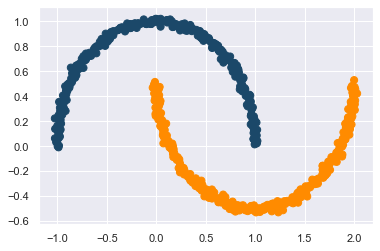

In [25]:
X_clean, y_clean = make_moons(n_samples = 600, noise=0.02, random_state=43)
show_Xy(X_clean, y_clean, 'DT-start-clean')

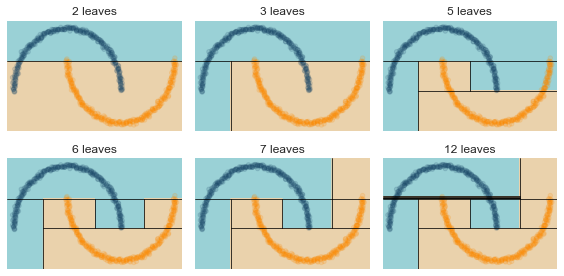

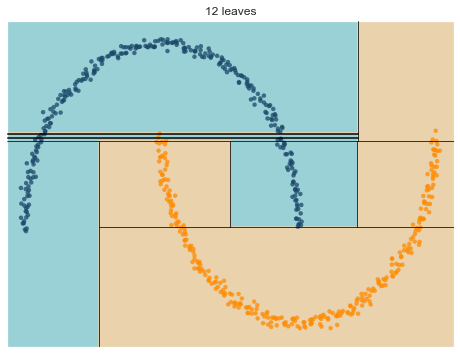

In [26]:
num_leaves_list = [2, 3, 5, 6, 7, 12]
make_leaves_grid(X_clean, y_clean, num_leaves_list, 'New Figure 11-15', 'New Figure 11-16')

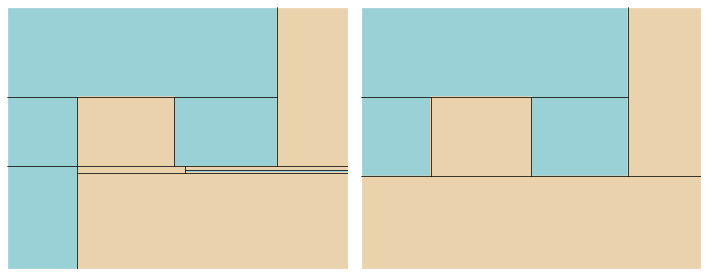

In [27]:
make_subsets_pair(X_clean, y_clean, 'New Figure 11-17')

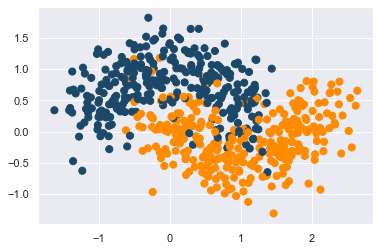

In [28]:
X_noisy, y_noisy = make_moons(n_samples = 600, noise=0.3, random_state=42)
show_Xy(X_noisy, y_noisy, 'DT-start-noisy')

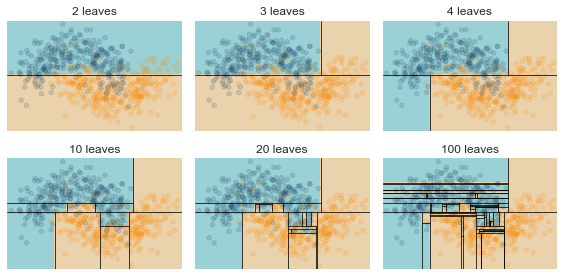

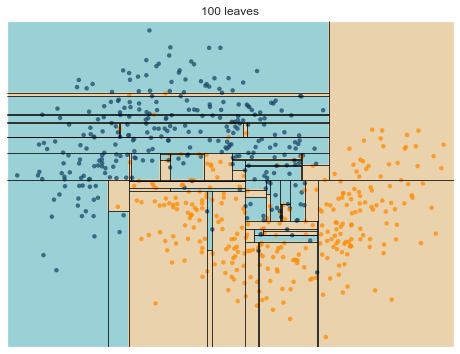

In [29]:
num_leaves_list = [2, 3, 4, 10, 20, 100]
make_leaves_grid(X_noisy, y_noisy, num_leaves_list, 'New Figure 11-19', 'New Figure 11-20')

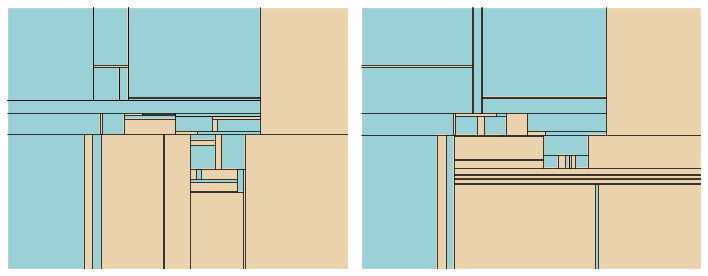

In [30]:
make_subsets_pair(X_noisy, y_noisy, 'New Figure 11-21')